# To ringformede ladninger 

I denne oppgaven skal vi finne det elektriske feltet og det elektriske potensialet først numerisk, og så ved en forenklet modell analytisk. 
Modellen som ble valgt er to ringformede ladninger med sentrum i z-aksen, en ring ved $z=\frac{-a}{2}$ med ladning $Q$, og den andre ved $z=\frac{a}{2}$ med ladning $-Q$. Ladningene er uniformt fordelt i ringene, og begge ringene har radius $a$ ut fra sentrum. Systemet vil se ut som dette:

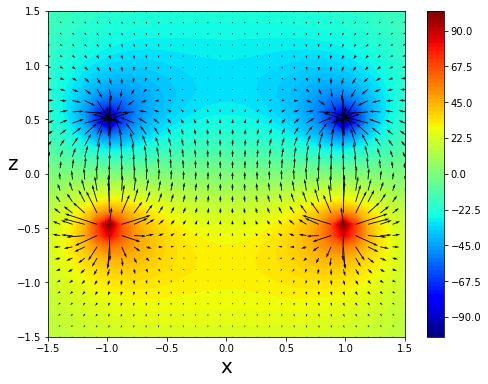

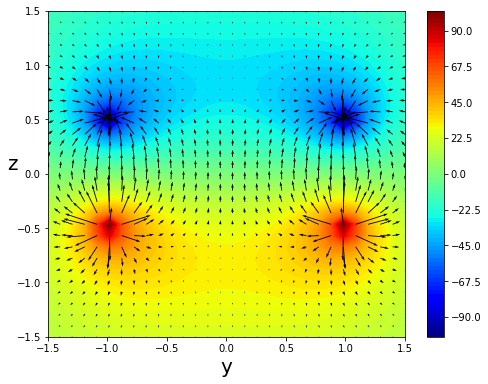

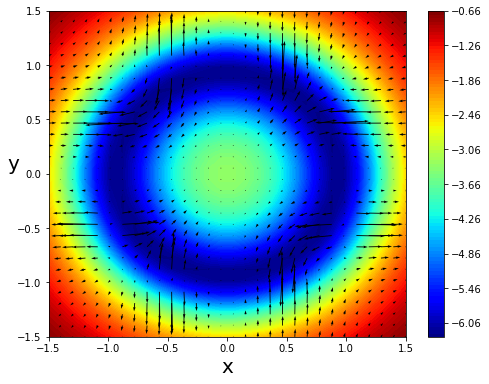

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from numba import njit
# Bruker Numba for å kompilere python-kode og speede opp kode

# Definerer universale konstanter her
epsilon_0 = sc.epsilon_0
@njit(cache=True)
def epot(r, qi, ri):    # Funksjon som regner elektrisk potensial i et punkt
    Ri = r - ri
    Rinorm = np.linalg.norm(Ri)
    V = qi / (4*np.pi*epsilon_0*Rinorm)
    return V

# Definerer parametere
a = 1
N = 20
Q = 1e-8
L = 1.5
NL = 30

# Lager linspace til meshgrid 
x = np.linspace(-L, L, NL)
y = np.linspace(-L, L, NL)
z = np.linspace(-L, L, NL)

# Lager meshgrid av 3D-rommet med indexing 'ij' (indeks grei for senere)
rx, ry, rz = np.meshgrid(x, y, z, indexing='ij')

@njit(cache=True)        # njitter funksjon så numba kjører den fort og lagrer verdiene med cache (njit = jit(nopython=True))
def f():
    # Regner ut potensialet i rommet 
    V = np.zeros((NL, NL, NL))
    for i in range(len(rx.flat)):
        # Array inneholdt alle punktene i rommet av meshgridet under indeks 
        r = np.array([rx.flat[i], ry.flat[i], rz.flat[i]])
        for j in range(N):
            theta = 2*np.pi / N*j
            r1 = np.array([a*np.cos(theta), a*np.sin(theta), -a/2])
            dq1 = Q/N
            dV1 = epot(r, dq1, r1)
            r2 = np.array([a*np.cos(theta), a*np.sin(theta), a/2])
            dq2 = -Q/N
            dV2 = epot(r, dq2, r2)
            V.flat[i] += dV1 + dV2
    return V

V = f()
Ex, Ey, Ez = np.gradient(-V)        # Potensialet er gradient av -V
"""
C er et heltall som bestemmer hvor man slicer xy, xz, og yz planet gjennom ringene.
C = int(np.ceil((NL - 1)/2)) garanterer at det er planene som skjærer origo, men f.eks 
C=10 gir at man skjærer nedre ringen gjennom xy-planet, slik at vi faktisk kan se de 20 punktene vi 
har lagt ladningsfordelingen på i koden (se N=20 over). Ved å sette C=0 får man alle startverdier 
(negative) fra meshet av rommet. C=-1 gir siste. Det er interessant å eksperimentere med disse 
verdiene for å se om feltet gir mening hele veien, kanskje sammenlikne med 3D-figur nederst på siden.
"""
C = int(np.ceil((NL - 1)/2))      # Finner indeks som ligger på midten så jeg finner planet som skjærer i origo

# Plotter potensialet i xz-planet ved y=0
fig = plt.figure(figsize=(8, 6))
pot = plt.contourf(rx[:,C], rz[C], V[:,C], cmap='jet', levels=100)    # Indeksering og slicing for riktig retning er viktig 
plt.xlabel('x', fontsize=20); plt.ylabel('z', fontsize=20, rotation=0)
plt.colorbar(pot)
plt.quiver(rx[:,C], rz[C], Ex[:,C], Ez[C])  # Pilplott i xz-planet
plt.show()

# Plotter potensialet i yz-planet ved x=0
fig = plt.figure(figsize=(8, 6))
pot = plt.contourf(ry[C], rz[C], V[C], cmap='jet', levels=100)    # Indeksering og slicing for riktig retning er viktig
plt.xlabel('y', fontsize=20); plt.ylabel('z', fontsize=20, rotation=0)
plt.colorbar(pot)
plt.quiver(ry[C], rz[C], Ey[C], Ez[C])      # Pilplott i xy-planet (burde være lik som xz-planet her)
plt.show()

# Plotter potensialet i xy-planet ved z=0
fig = plt.figure(figsize=(8, 6))
pot = plt.contourf(rx[:,C], ry[C].T, V[:,:,C], cmap='jet', levels=100)    # Indeksering og slicing for riktig retning er viktig
plt.xlabel('x', fontsize=20); plt.ylabel('y', fontsize=20, rotation=0)
plt.colorbar(pot)
plt.quiver(rx[:,C], ry[C].T, Ex[:,C], Ey[C].T)      # Pilplott i xy-planet (burde være lik som xz-planet her)
plt.show()


På grunn av den underliggende symmetrien i ringene og uniform ladningsfordeling forventer jeg at det elektriske feltet og potensiale også er symmetrisk i xz og yz-planet. Derfor plottet jeg felt og potensial i både xz-planet og yz-planet, og som resultatene viser er det identiske plott slik jeg forventet. Det planet som kanskje var vanskeligere å gjette på hvordan ville se ut var xy-planet, som viser oss at potensialet ligger som en slags torus der z=0. 

La oss løse en noe forenklet modell for denne analytisk, og se om systemet oppfører seg slik vi kunne forvente. Vi starter først med å se på systemet langt unna, slik at vi kan approksimere ringladningene til punktladninger istedet, altså en velkjent dipol. Det vi nå ser på da er to punktladninger plassert på $z=\frac{-a}{2}$ og $z=\frac{a}{2}$ med ladning $Q$ og $-Q$. Vi ser på en ladning plassert i en avstnand $r$ et godt stykke unna, og kan da sette opp uttrykket for totalt potensiale for ladningen:
\begin{align*}
V(r) &= V_{Q} + V_{-Q} \\
&= \frac{Q}{4\pi\epsilon_0 r_{Q}} + \frac{-Q}{4\pi\epsilon_0 r_{-Q}} \\
&= \frac{Q}{4\pi\epsilon_0}\left(\frac{1}{r_{Q}} - \frac{1}{r_{-Q}}\right) \\
&= \frac{Q}{4\pi\epsilon_0}\left(\frac{r_{-Q} - r_{Q}}{r_{Q}r_{-Q}}\right)
\end{align*}

Der $V_{Q}$ og $V_{-Q}$ er bidraget i potensiale fra hver punktladning.
For å ta det videre uten at det blir for komplisert skal vi gjøre en liten geometrisk betrakning illustrert nedenfor:

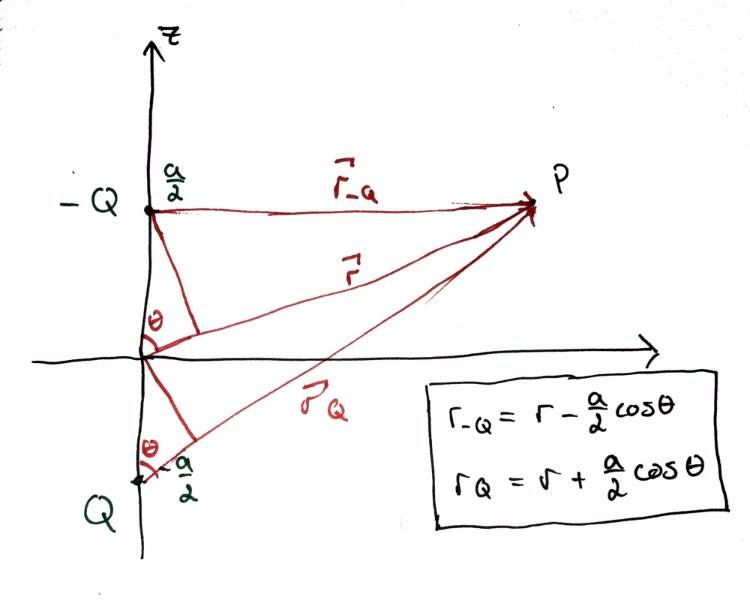

Da blir det enklere å regne det analytiske uttrykket. Videre har vi da:
\begin{align*}
r_{-Q} &= r - \frac{a}{2}cos(\theta) \\
r_{Q} &= r + \frac{a}{2}cos(\theta), \\
r_{Q}\cdot r_{-Q} &= (r - \frac{a}{2}cos(\theta))(r + \frac{a}{2}cos(\theta)) \\
&= r^2 - \frac{a^2}{4}cos^2(\theta) \\
r_{-Q} - r_{Q} &= r - \frac{a}{2}cos(\theta) - r - \frac{a}{2}cos(\theta) \\
&= -acos(\theta)
\end{align*}

Siden vi har antatt at $r>>a$ (vi ser på en avstand langt unna), så blir $r^2 - \frac{a^2}{4}cos^2(\theta) \approx r^2$. Setter vi dette inn i uttrykkene for potensial ovenfor får vi:
\begin{align*}
V(r) &= \frac{Q}{4\pi\epsilon_0}\left(\frac{r_{-Q} - r_{Q}}{r_{Q}r_{-Q}}\right) \\
&= \frac{Q}{4\pi\epsilon_0}\left(\frac{-acos(\theta)}{r^2}\right)
\end{align*}
Her ser vi at ifølge den forenklede modellen vil potensialet avta med $r^2$ dersom vi er langt unna. Vi prøver å plotte den analytiske modellen med den numeriske, og ser hva slasg resultater vi får.

In [ ]:
# Plotter log av potensialet på log av avstanden
@njit(cache=True)
def f():
    N = 10000
    dx = 0.0001
    x = np.linspace(dx, 1000, N)
    y = np.linspace(dx, 1000, N)
    z = np.linspace(dx, 1000, N)
    Vs = np.zeros(x.shape)
    for i in range(len(x)):
        # Array med punkter i rommet
        r = np.array([x[i], y[i], z[i]])
        for j in range(N):
            theta = 2*np.pi / N*j
            r1 = np.array([a*np.cos(theta), a*np.sin(theta), -a/2])
            dq1 = Q/N
            dV1 = epot(r, dq1, r1)
            r2 = np.array([a*np.cos(theta), a*np.sin(theta), a/2])
            dq2 = -Q/N
            dV2 = epot(r, dq2, r2)
            Vs[i] += dV1 + dV2
    return x, y, z, Vs

x, y, z, Vr = f()
r = np.sqrt(x**2 + y**2 + z**2)
rlog = np.log10(r)
Vrlog = np.log10(abs(Vr))
# Merk: Jeg inkluderer ikke acos(theta)-leddet, fordi jeg ikke vet hva theta vil være. Dermed forventer jeg at når jeg plotter
# så vil ikke grafene ligge på samme verdier, men det er forsåvidt uinteressant. Det jeg er interessert i er om de har samme 
# stigningstall
Vanalytical_log = np.log10(abs(Q/(4*np.pi*epsilon_0) * (-1 / r**2)))

fig = plt.figure(figsize=(8, 6))
plt.plot(rlog, Vrlog, label='Numerical')
plt.plot(rlog, Vanalytical_log, label='Analytical')
plt.xlabel('log(r)', fontsize=20); plt.ylabel(r'$log(V_r)$', fontsize=20)
plt.legend()
plt.show()
p = np.polyfit(rlog, Vrlog, 1)
print(p)


I plottet ovenfor har jeg ikke inkludert $acos(\theta)$-leddet i det analytiske uttrykket, fordi jeg ikke vet hva $\theta$ er. Siden det bare er en konstant bidrar den kun med hvor det analytiske uttrykket skjærer y-aksen, som forsåvidt er uinteressant for meg. Det jeg er mest interessert i er å se om det analytiske uttrykket har samme stigningstall som den numeriske dataen som er plottet. Polyfit-funksjonen returnerer en stigning på ca. -2 fra den numeriske dataen, som stemmer veldig bra med det analytiske uttrykket. Plottet ovenfor viser potensialet på en liten ladning $q$ langs en linje der $\vec{r}=(x,y,z),\:x=y=z$ som går mot uendelig. 

Dersom jeg vil være helt sikker på det analytiske uttrykket mot det numeriske, kan jeg begrense meg til å se på potensialet langs z-aksen, siden der vet jeg at $\theta=0$ og vi får et konkret uttrykk der alle parametere er kjent for det analytiske potensialet. Vi kan ta en kjapp titt på det plottet også:

In [ ]:
# Plotter log av potensialet på log av avstanden
@njit(cache=True)
def f():
    N = 10000
    dx = 0.0001
    x = np.linspace(dx, 1000, N)
    y = np.linspace(dx, 1000, N)
    z = np.linspace(dx, 1000, N)
    Vs = np.zeros(x.shape)
    for i in range(len(x)):
        # Array med punkter langs z-aksen
        r = np.array([0, 0, z[i]])
        for j in range(N):
            theta = 2*np.pi / N*j
            r1 = np.array([a*np.cos(theta), a*np.sin(theta), -a/2])
            dq1 = Q/N
            dV1 = epot(r, dq1, r1)
            r2 = np.array([a*np.cos(theta), a*np.sin(theta), a/2])
            dq2 = -Q/N
            dV2 = epot(r, dq2, r2)
            Vs[i] += dV1 + dV2
    return x, y, z, Vs

x, y, z, Vr = f()
r = np.sqrt(z**2)
rlog = np.log10(r)
Vrlog = np.log10(abs(Vr))
# Her vil cos(theta) = 1 i det analytiske uttrykket, siden theta er 0
Vanalytical_log = np.log10(abs(Q/(4*np.pi*epsilon_0) * (-a / z**2)))

fig = plt.figure(figsize=(8, 6))
plt.plot(rlog, Vrlog, label='Numerical')
plt.plot(rlog, Vanalytical_log, label='Analytical')
plt.xlabel('log(z)', fontsize=20); plt.ylabel(r'$log(V_z)$', fontsize=20)
plt.legend()
plt.show()
p = np.polyfit(rlog, Vrlog, 1)
print(p)


Her ser vi at dataen linjer opp ganske presist oppå hverandre langs z-aksen, og jeg er veldig sikker på at det analytiske uttrykket er en god approksimasjon for potensialet av modellen på lang avstand. 

In [ ]:
# Definerer universale konstanter her
epsilon_0 = sc.epsilon_0
@njit(cache=True)
def epot(r, qi, ri):    # Funksjon som regner elektrisk potensial i et punkt
    Ri = r - ri
    Rinorm = np.linalg.norm(Ri)
    V = qi / (4*np.pi*epsilon_0*Rinorm)
    return V

# Definerer parametere
a = 1
N = 20
Q = 1e-8
L = 1.5
NL = 12

x = np.linspace(-L, L, NL)
y = np.linspace(-L, L, NL)
z = np.linspace(-L, L, NL)

# Lager meshgrid av 3D-rommet med indexing 'ij' (indeks grei for senere)
rx, ry, rz = np.meshgrid(x, y, z, indexing='ij')

@njit(cache=True)
def f():
    V = np.zeros((NL, NL, NL))
    for i in range(len(rx.flat)):
        r = np.array([rx.flat[i], ry.flat[i], rz.flat[i]])
        for j in range(N):
            theta = 2*np.pi / N*j
            r1 = np.array([a*np.cos(theta), a*np.sin(theta), -a/2])
            dq1 = Q/N
            dV1 = epot(r, dq1, r1)
            r2 = np.array([a*np.cos(theta), a*np.sin(theta), a/2])
            dq2 = -Q/N
            dV2 = epot(r, dq2, r2)
            V.flat[i] += dV1 + dV2
    return V

V = f()
Ex, Ey, Ez = np.gradient(-V)        # Potensialet er gradient av -V


# Videre til å plotte i 3D:
# Må gjøre dette for å få laget med cmap på 3D-quiver
# dette handler kun om farger på 3D-pilplott
k = np.sqrt(Ex**2 + Ey**2 + Ez**2)      # Vil gradere farge utifar størrelse på felt
# Flat ned og normaliser
c = np.ravel(k) / np.ptp(k)     # Ravel flater ned dimensjonene til en array
c = np.concatenate((c, np.repeat(c, 2)))        # Gjentar c 2 ganger og konkatenerer så lista ikke går tom for verdier
c = plt.cm.jet(c)           # Henter fargekart og legger inn fargeskala

# print(np.ptp(c) == np.max(c) - np.min(c))     # Returnerer True, ptp - peak to peak

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x', fontsize=16); ax.set_ylabel('y', fontsize=16); ax.set_zlabel('z', fontsize=16)
len = 1 / (1.5*np.max(np.sqrt(Ex**2 + Ey**2 + Ez**2)))
quiver_3d = ax.quiver(rx, ry, rz, Ex, Ey, Ez, colors=c, cmap='jet', length=len, arrow_length_ratio=0.5)
cbar = fig.colorbar(quiver_3d, ax=ax)
# Få på plass riktige verdier på cbar
# definerer funksjon som runder opp tall til andre desimal siden map-funksjon lenger ned ikke aksepterer round() direkte
rnd = lambda t: round(t, 3)
N = 10      # Antall ticklabels ønsket
cbar.set_ticks(np.linspace(0, 1, N))
cbar.set_label(r'Strength of $\vec{E}$', fontsize=20)
cbar.set_ticklabels([*map(rnd, np.linspace(np.min(k), np.max(k), N))])  # map sender alle gitte-verdier gjennom gitt funksjon, jeg pakker dem ut
plt.show()
